In [2]:
import os
import random

import numpy as np
import pandas as pd
import pdb
from collections import OrderedDict
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import collections  as mc
matplotlib.rcParams['figure.figsize'] = [5, 5]
matplotlib.rcParams['figure.dpi'] = 200

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms

from data_helper import UnlabeledDataset, LabeledDataset
from helper import collate_fn, draw_box

random.seed(0)
np.random.seed(0)
torch.manual_seed(0);

# All the images are saved in image_folder
# All the labels are saved in the annotation_csv file
image_folder = '/scratch/vr1059/self-driving-data/data'
annotation_csv = '/scratch/vr1059/self-driving-data/data/annotation.csv'

# You shouldn't change the unlabeled_scene_index
# The first 106 scenes are unlabeled
unlabeled_scene_index = np.arange(106)
# The scenes from 106 - 133 are labeled
# You should devide the labeled_scene_index into two subsets (training and validation)
train_labeled_scene_index = np.arange(106, 128)
val_labeled_scene_index = np.arange(128, 132)
test_labeled_scene_index = np.arange(132, 134)

In [3]:
def unit_vector(vector):
    """ Returns the unit vector of the vector.  """
    return vector / np.linalg.norm(vector)

def angle_between(v1, v2):
    """ Returns the angle in radians between vectors 'v1' and 'v2'::

            >>> angle_between((1, 0, 0), (0, 1, 0))
            1.5707963267948966
            >>> angle_between((1, 0, 0), (1, 0, 0))
            0.0
            >>> angle_between((1, 0, 0), (-1, 0, 0))
            3.141592653589793
    """
    v1_u = unit_vector(v1)
    v2_u = unit_vector(v2)
    return np.degrees(np.arccos(np.clip(np.dot(v1_u, v2_u), -1.0, 1.0)))

In [112]:
class_label = 1
class_dict = dict()
reverse_class_dict = []
reverse_class_dict.append((-100, -100))
for i in range(400, 800, 50):
    for j in range(200, 600, 50):
        class_dict[(i, j)] = class_label
        class_label += 1
        reverse_class_dict.append((i, j))
        
class_dict[(-100, -100)] = 0

In [113]:
class_dict

{(400, 200): 1,
 (400, 250): 2,
 (400, 300): 3,
 (400, 350): 4,
 (400, 400): 5,
 (400, 450): 6,
 (400, 500): 7,
 (400, 550): 8,
 (450, 200): 9,
 (450, 250): 10,
 (450, 300): 11,
 (450, 350): 12,
 (450, 400): 13,
 (450, 450): 14,
 (450, 500): 15,
 (450, 550): 16,
 (500, 200): 17,
 (500, 250): 18,
 (500, 300): 19,
 (500, 350): 20,
 (500, 400): 21,
 (500, 450): 22,
 (500, 500): 23,
 (500, 550): 24,
 (550, 200): 25,
 (550, 250): 26,
 (550, 300): 27,
 (550, 350): 28,
 (550, 400): 29,
 (550, 450): 30,
 (550, 500): 31,
 (550, 550): 32,
 (600, 200): 33,
 (600, 250): 34,
 (600, 300): 35,
 (600, 350): 36,
 (600, 400): 37,
 (600, 450): 38,
 (600, 500): 39,
 (600, 550): 40,
 (650, 200): 41,
 (650, 250): 42,
 (650, 300): 43,
 (650, 350): 44,
 (650, 400): 45,
 (650, 450): 46,
 (650, 500): 47,
 (650, 550): 48,
 (700, 200): 49,
 (700, 250): 50,
 (700, 300): 51,
 (700, 350): 52,
 (700, 400): 53,
 (700, 450): 54,
 (700, 500): 55,
 (700, 550): 56,
 (750, 200): 57,
 (750, 250): 58,
 (750, 300): 59,
 (750,

In [103]:
def round_up(x):
    return int(math.ceil(x / 50.0)) * 50

def round_down(x):
    return round_up(x) - 50

In [104]:
def front_collate_fn(batch):
    front_imgs = []
    front_right_imgs = []
    front_left_imgs = []
    target = []
    road_imgs = []
    bbs = []
    for x in batch:
        # input
        front_left_imgs.append(torch.tensor(x[0][0]))
        front_imgs.append(torch.tensor(x[0][1]))
        front_right_imgs.append(torch.tensor(x[0][2]))
        road_imgs.append(torch.tensor(x[2]))
        
        # target
        bb_tens = x[1]['bounding_box']
        bbs.append(bb_tens)
        x_min = 800
        bb_cand = (-100, -100)
        
        for i, corners in enumerate(bb_tens):
            # Get bird's eye view coordinates. 
            point_squence = torch.stack([corners[:, 0], corners[:, 1], corners[:, 3], corners[:, 2]])
            xs = point_squence.T[0] * 10 + 400
            ys = -point_squence.T[1] * 10 + 400
            if xs[2] - xs[0] > 5:
                top_center_x, top_center_y = 0.5*(xs[2] + xs[3]), 0.5*(ys[2] + ys[3])
            else:
                top_center_x, top_center_y = 0.5*(xs[0] + xs[1]), 0.5*(ys[0] + ys[1])
                
            # We do (800 - top_center_y) because matplotlib y-axis starts from the top. 
            v1 = np.array([top_center_x - 400, 800 - top_center_y - 400])
            v2 = np.array([2, 0])
            
            if abs(angle_between(v1, v2)) <= 35 and x[1]['category'][i] not in [1, 3, 6, 8]:
                if top_center_x < x_min:
                    x_min = top_center_x
                    bb_cand = (top_center_x.item(), top_center_y.item())
         
        if int(bb_cand[0]) == -100:
            target.append((0, bb_cand[0], bb_cand[1]))
        else:
            key = (round_down(bb_cand[0]), round_down(bb_cand[1]))
            if key not in class_dict:
                print(bb_cand)
            label = class_dict[key]
            target.append((label, bb_cand[0], bb_cand[1]))
                
    boom = torch.stack(front_imgs), torch.tensor(target), torch.stack(road_imgs), bbs, torch.stack(front_right_imgs), torch.stack(front_left_imgs)
    return boom

### Dataset

In [105]:
# The labeled dataset can only be retrieved by sample.
# And all the returned data are tuple of tensors, since bounding boxes may have different size
# You can choose whether the loader returns the extra_info. It is optional. You don't have to use it.
val_transform = transforms.ToTensor()
train_transform = transforms.Compose([
    transforms.RandomApply([
        transforms.ColorJitter(brightness = 0.5, contrast = 0.3, saturation = 0.2, hue = (-0.3, 0.3)),
        transforms.RandomAffine(10),
    ]),
    transforms.ToTensor(),
])
labeled_trainset = LabeledDataset(image_folder=image_folder,
                                  annotation_file=annotation_csv,
                                  scene_index=train_labeled_scene_index,
                                  transform=train_transform,
                                  extra_info=True
                                 )
labeled_valset = LabeledDataset(image_folder=image_folder,
                                  annotation_file=annotation_csv,
                                  scene_index=val_labeled_scene_index,
                                  transform=val_transform,
                                  extra_info=True
                                 )

train_loader = torch.utils.data.DataLoader(labeled_trainset, batch_size=48, shuffle=True, collate_fn=front_collate_fn)
val_loader = torch.utils.data.DataLoader(labeled_valset, batch_size=48, shuffle=False, collate_fn=front_collate_fn)


In [106]:
sample, target, road_img, bbs, front_right, front_left = iter(train_loader).next()

/home/vr1059/py3.6.3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # Remove the CWD from sys.path while we load stuff.
/home/vr1059/py3.6.3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # This is added back by InteractiveShellApp.init_path()
/home/vr1059/py3.6.3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == '':
/home/vr1059/py3.6.3/lib/python3.6/site-packages/ip

In [107]:
idx = 0

In [127]:
idx += 1

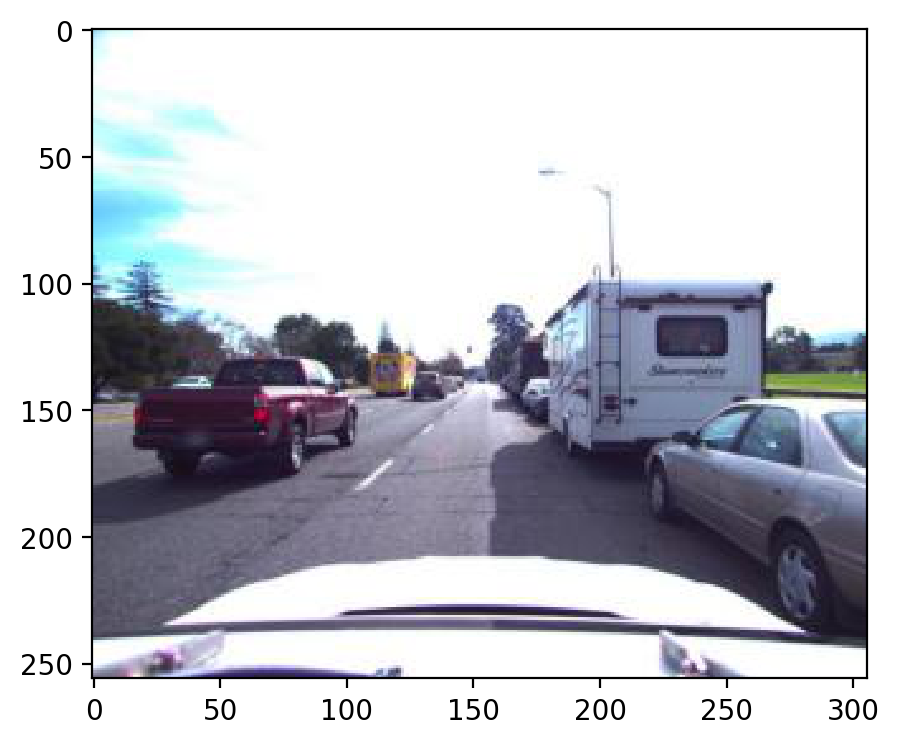

In [128]:
plt.imshow(sample[idx].cpu().detach().numpy().transpose(1, 2, 0))

[]

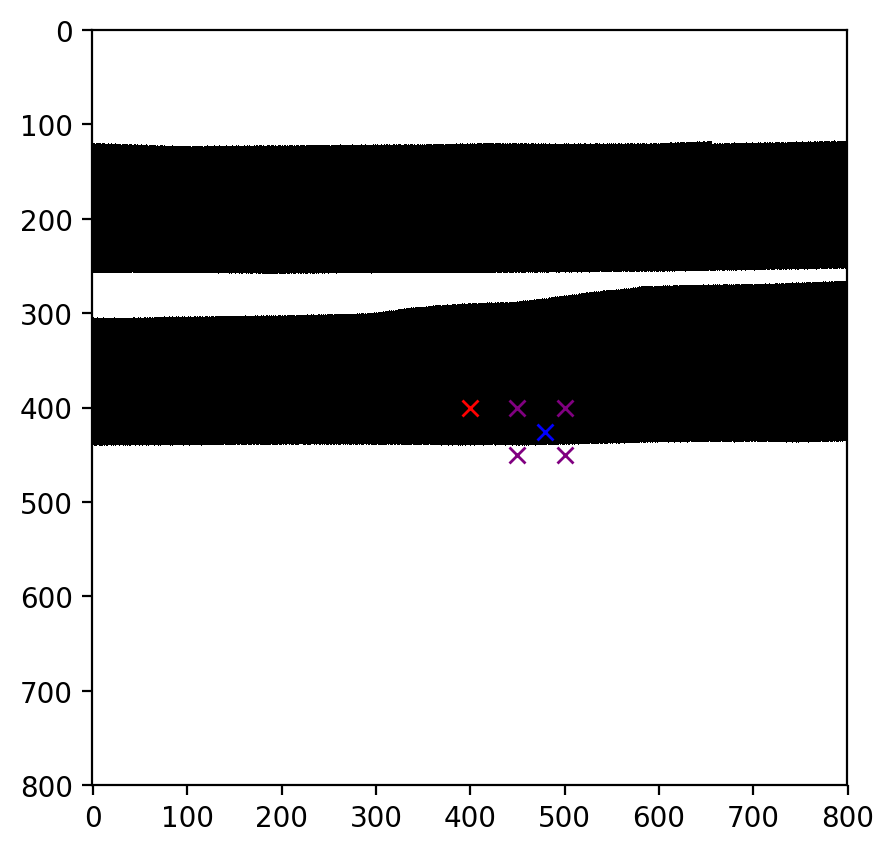

In [129]:
fig, ax = plt.subplots()
ax.imshow(road_img[idx], cmap ='binary');
ax.plot(400, 400, 'x', color="red")
ax.plot(target[idx][1], target[idx][2], 'x', color="blue")
class_box = reverse_class_dict[int(target[idx][0].item())]
box_xs = [class_box[0], class_box[0], class_box[0]+50, class_box[0]+50]
box_ys = [class_box[1], class_box[1]+50, class_box[1], class_box[1]+50]
ax.plot(box_xs, box_ys, 'x', color="purple")
ax.plot()

In [28]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class SimpleModel(nn.Module):
    def __init__(self):
        super(SimpleModel, self).__init__()
        
        self.encoder = torchvision.models.resnet18()
        self.encoder.fc = nn.Identity()
        
        self.regression = nn.Sequential(OrderedDict([
            ('linear1', nn.Linear(512, 256)),
            ('bn1', nn.BatchNorm1d(256)),
            ('relu1', nn.ReLU()),
            ('linear2', nn.Linear(256, 2))
        ]))
        
#         self.regression.linear1.bias = nn.Parameter(torch.tensor(400.))
        
    def forward(self, x):
        x = self.encoder(x)
        return self.regression(x)
    
model = SimpleModel().to(device)

### Train/Val

In [29]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
best_val_loss = 100

In [30]:
def train():
    model.train()
    train_losses = []
    for i, (sample, target, road_img, bbs, front_right, front_left) in enumerate(train_loader):

        optimizer.zero_grad()

        sample = sample.to(device)
        target = target.to(device)

        target = target/100.

        y_hat = model(sample)
        target = target[:, :2]
        loss = criterion(y_hat, target)
        
        train_losses.append(loss.item())

        loss.backward()
        optimizer.step()

        if i % 10 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, i * len(sample), len(train_loader.dataset),
                10. * i / len(train_loader), loss.item()))
            
    print("\nAverage Train Epoch Loss: ", np.mean(train_losses))
            
def val():
    model.eval()
    val_losses = []
    for i, (sample, target, road_img, bbs, front_right, front_left) in enumerate(val_loader):

        model.eval()

        sample = sample.to(device)
        target = target.to(device)

        with torch.no_grad():
            target = target/100.

            y_hat = model(sample)
            target = target[:, :2]
            loss = criterion(y_hat, target)

            val_losses.append(loss.item())

#         if i % 5 == 0:
#             print('Val Epoch: {} [{}/{} ({:.0f}%)]\tAverage Loss So Far: {:.6f}'.format(
#                 epoch, i * len(sample), len(val_loader.dataset),
#                 5. * i / len(val_loader), np.mean(val_losses)))
            
    print("Average Validation Epoch Loss: ", np.mean(val_losses))
    global best_val_loss
    if np.mean(val_losses) < best_val_loss:
        best_val_loss = np.mean(val_losses)
        torch.save(model.state_dict(), 'best_val_loss_simple.pt')

In [31]:
import math
def find_lr(model, loss_fn, optimizer, init_value=1e-8, final_value=10.0):
    number_in_epoch = len(train_loader) - 1
    update_step = (final_value / init_value) ** (1 / number_in_epoch)
    lr = init_value
    optimizer.param_groups[0]["lr"] = lr
    best_loss = 0.0
    batch_num = 0
    losses = []
    log_lrs = []
    for (sample, target, road_img, bbs, front_right, front_left) in train_loader:
        batch_num += 1
        optimizer.zero_grad()
        
        sample = sample.to(device)
        target = target.to(device)

        target = target/100.

        y_hat = model(sample)
        target = target[:, :2]
        loss = loss_fn(y_hat, target)

        # Crash out if loss explodes

        if batch_num > 1 and loss > 4 * best_loss:
            return log_lrs[10:-5], losses[10:-5]

        # Record the best loss

        if loss < best_loss or batch_num == 1:
            best_loss = loss

        # Store the values

        losses.append(loss)
        log_lrs.append(math.log10(lr))

        # Do the backward pass and optimize

        loss.backward()
        optimizer.step()

        # Update the lr for the next step and store

        lr *= update_step
        optimizer.param_groups[0]["lr"] = lr
    return log_lrs[10:-5], losses[10:-5]

In [32]:
model = SimpleModel().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [33]:
# logs,losses = find_lr(model, criterion, optimizer)

In [35]:
epochs = 40
for epoch in range(epochs):
    train()
    val()

/home/vr1059/py3.6.3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # Remove the CWD from sys.path while we load stuff.
/home/vr1059/py3.6.3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # This is added back by InteractiveShellApp.init_path()
/home/vr1059/py3.6.3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == '':
/home/vr1059/py3.6.3/lib/python3.6/site-packages/ip

Train Epoch: 0 [0/2772 (0%)]	Loss: 0.695661
Train Epoch: 0 [480/2772 (2%)]	Loss: 1.000694
Train Epoch: 0 [960/2772 (3%)]	Loss: 0.806433
Train Epoch: 0 [1440/2772 (5%)]	Loss: 2.227913
Train Epoch: 0 [1920/2772 (7%)]	Loss: 1.018627
Train Epoch: 0 [2400/2772 (9%)]	Loss: 1.185318

Average Train Epoch Loss:  1.299392641104501
Average Validation Epoch Loss:  3.490591921589591
Train Epoch: 1 [0/2772 (0%)]	Loss: 1.195924
Train Epoch: 1 [480/2772 (2%)]	Loss: 1.010710
Train Epoch: 1 [960/2772 (3%)]	Loss: 0.393582
Train Epoch: 1 [1440/2772 (5%)]	Loss: 2.925826
Train Epoch: 1 [1920/2772 (7%)]	Loss: 0.791992
Train Epoch: 1 [2400/2772 (9%)]	Loss: 1.147442

Average Train Epoch Loss:  1.154764943852507
Average Validation Epoch Loss:  3.3412745479832995
Train Epoch: 2 [0/2772 (0%)]	Loss: 5.000212
Train Epoch: 2 [480/2772 (2%)]	Loss: 0.589074
Train Epoch: 2 [960/2772 (3%)]	Loss: 1.571824
Train Epoch: 2 [1440/2772 (5%)]	Loss: 1.843809
Train Epoch: 2 [1920/2772 (7%)]	Loss: 0.394989
Train Epoch: 2 [2400/27

KeyboardInterrupt: 

In [ ]:
model.load_state_dict(torch.load('best_val_loss_simple.pt'))

val_losses = []
for i, (sample, target, road_img, bbs, front_right, front_left) in enumerate(val_loader):
    
    model.eval()
    
    sample = sample.to(device)
    target = target.to(device)
    
    with torch.no_grad():
        target = target/100.

        y_hat = model(sample)
        target = target[:, :2]
        loss = criterion(y_hat, target)
        
        val_losses.append(loss.item())
    
    if i % 5 == 0:
        print('Val Epoch: {} [{}/{} ({:.0f}%)]\tAverage Loss So Far: {:.6f}'.format(
            0, i * len(sample), len(val_loader.dataset),
            5. * i / len(val_loader), np.mean(val_losses)))

In [38]:
labeled_testset = LabeledDataset(image_folder=image_folder,
                                  annotation_file=annotation_csv,
                                  scene_index=test_labeled_scene_index,
                                  transform=val_transform,
                                  extra_info=True
                                 )

test_loader = torch.utils.data.DataLoader(labeled_testset, batch_size=32, shuffle=False, collate_fn=front_collate_fn)

In [ ]:
model.load_state_dict(torch.load('best_val_loss_simple.pt'))

test_losses = []
for i, (sample, target, road_img, bbs, front_right, front_left) in enumerate(test_loader):
    
    model.eval()
    
    sample = sample.to(device)
    target = target.to(device)
    
    with torch.no_grad():
        target = target/100.

        y_hat = model(sample)
        target = target[:, :2]
        loss = criterion(y_hat, target)
        
        test_losses.append(loss.item())
    
print("Average Test Loss: ", np.mean(test_losses))

In [39]:
test_loader = torch.utils.data.DataLoader(labeled_testset, batch_size=32, shuffle=True, collate_fn=front_collate_fn)

In [40]:
sample, target, road_img, bbs, front_right, front_left = iter(test_loader).next()
sample = sample.to(device)
model_preds = model(sample)

/home/vr1059/py3.6.3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # Remove the CWD from sys.path while we load stuff.
/home/vr1059/py3.6.3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # This is added back by InteractiveShellApp.init_path()
/home/vr1059/py3.6.3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == '':
/home/vr1059/py3.6.3/lib/python3.6/site-packages/ip

In [ ]:
model_preds

In [42]:
idx = 5

In [43]:
idx += 1

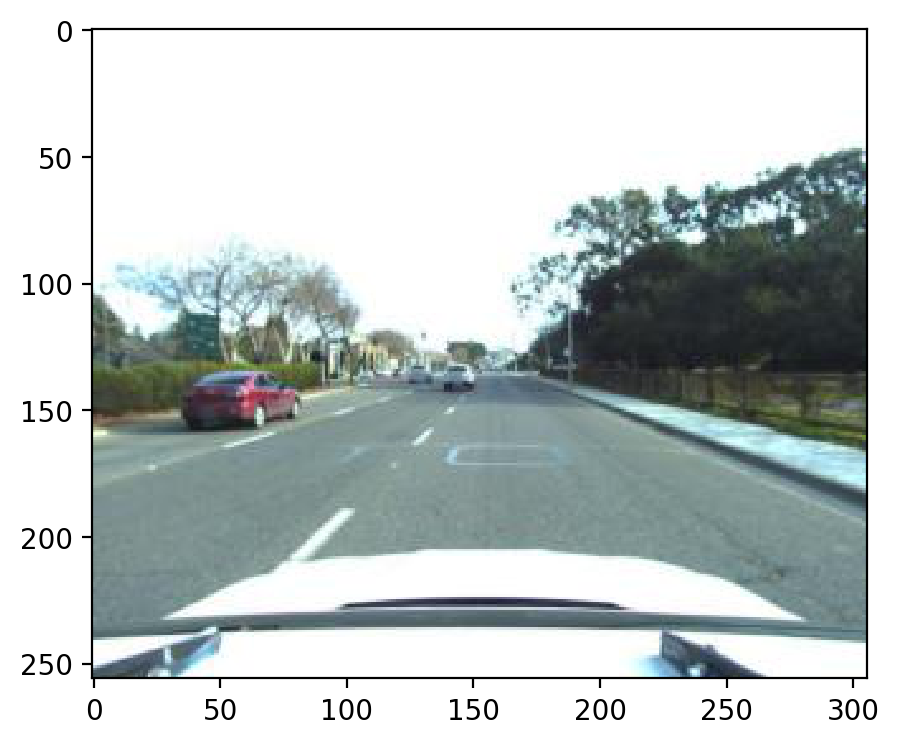

In [44]:
plt.imshow(sample[idx].cpu().detach().numpy().transpose(1, 2, 0))

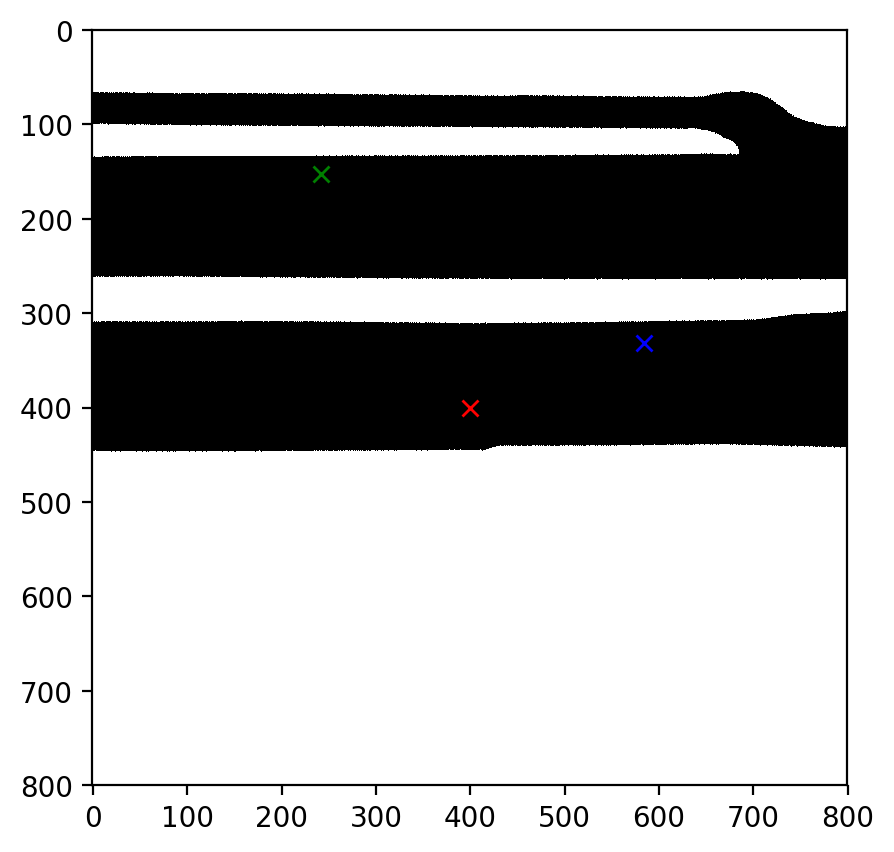

In [45]:
fig, ax = plt.subplots()
ax.imshow(road_img[idx], cmap ='binary');
ax.plot(400, 400, 'x', color="red")
ax.plot(target[idx][0], target[idx][1], 'x', color="blue")
ax.plot(model_preds[idx][0].cpu().detach().numpy()*100, model_preds[idx][1].cpu().detach().numpy()*100, 'x', color="green")


In [ ]:
val_loader = torch.utils.data.DataLoader(labeled_valset, batch_size=20, shuffle=True, collate_fn=front_collate_fn)
sample, target, road_img, bbs, front_right, front_left = iter(val_loader).next()
sample = sample.to(device)
target = target.to(device)
model.eval()
target/100.

In [ ]:
model(sample)

In [ ]:
sample, target, road_img, bbs, front_right, front_left = iter(train_loader).next()

In [ ]:
sample.shape

In [ ]:
target

In [ ]:
idx = 0
plt.imshow(sample[idx][:, :, :].numpy().transpose(1, 2, 0))
# plt.imshow(front_right[idx][:, :, :].numpy().transpose(1, 2, 0))

In [ ]:
fig, ax = plt.subplots()
ax.imshow(road_img[idx], cmap ='binary');
ax.plot(400, 400, 'x', color="red")
ax.plot(target[idx][0], target[idx][1], 'x', color="blue")